In [149]:
#from nsepy import get_history
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import quandl

start = date(2013,1,1)
end= date.today()


In [150]:
quandl.connection.ApiConfig.api_key= "_N85bWLCNCWz14smKHSi"

In [151]:
data = quandl.get('WIKI/AMZN',start_date=start,end_date=end)

In [152]:
data.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2013-01-02,256.08,258.0999,253.260,257.3100,3271000.0,0.0,1.0,256.08,258.0999,253.260,257.3100,3271000.0
2013-01-03,257.27,260.8800,256.370,258.4800,2750900.0,0.0,1.0,257.27,260.8800,256.370,258.4800,2750900.0
2013-01-04,257.58,259.8000,256.650,259.1500,1874200.0,0.0,1.0,257.58,259.8000,256.650,259.1500,1874200.0
2013-01-07,262.97,269.7250,262.670,268.4592,4910000.0,0.0,1.0,262.97,269.7250,262.670,268.4592,4910000.0
2013-01-08,267.07,268.9800,263.567,266.3800,3010700.0,0.0,1.0,267.07,268.9800,263.567,266.3800,3010700.0


In [153]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Ex-Dividend', 'Split Ratio',
       'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume'],
      dtype='object')

In [154]:

# Specify the test data size
test_size=60
# To avoid any look forward bias we will be taking only the train data to scale the data
max_=data.iloc[:-test_size][['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close']].max().max()
min_=data.iloc[:-test_size][['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close']]-min_)/(max_-min_)
scl.fit(data[['Adj. Volume']].iloc[:-test_size].values.reshape(-1,1))
X2=scl.transform(data[['Adj. Volume']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data.tail()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2018-03-21,1.385507,1.389176,1.361449,1.380764,0.157023,0.0,1.0,1586.45,1590.00,1563.17,1581.86,4667291.0
2018-03-22,1.363826,1.372486,1.339985,1.341742,0.223378,0.0,1.0,1565.47,1573.85,1542.40,1544.10,6177737.0
2018-03-23,1.336482,1.346826,1.291373,1.291580,0.296576,0.0,1.0,1539.01,1549.02,1495.36,1495.56,7843966.0
2018-03-26,1.327171,1.355063,1.295393,1.353895,0.195696,0.0,1.0,1530.00,1556.99,1499.25,1555.86,5547618.0
2018-03-27,1.370988,1.374667,1.277897,1.293119,0.250419,0.0,1.0,1572.40,1575.96,1482.32,1497.05,6793279.0


In [155]:
X=data[['Open', 'High', 'Low', 'Close', 'Volume']]
y=data['Adj. Close'].shift(-1)

In [156]:
X.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2018-03-21,1.385507,1.389176,1.361449,1.380764,0.157023
2018-03-22,1.363826,1.372486,1.339985,1.341742,0.223378
2018-03-23,1.336482,1.346826,1.291373,1.291580,0.296576
2018-03-26,1.327171,1.355063,1.295393,1.353895,0.195696
2018-03-27,1.370988,1.374667,1.277897,1.293119,0.250419


In [157]:
y.tail()

Date
2018-03-21    1544.10
2018-03-22    1495.56
2018-03-23    1555.86
2018-03-26    1497.05
2018-03-27        NaN
Name: Adj. Close, dtype: float64

In [158]:
timestep=1
X_list=[]
y_list=[]
for i in range(timestep,len(X)):
    X_list.append(np.array(X.iloc[i-timestep:i]))
    y_list.append(y.iloc[i:i+timestep].values)

In [159]:
X_train=np.array(X_list[:-test_size])
y_train=np.expand_dims(np.array(y_list[:-test_size]),axis=2)
X_test=np.array(X_list[-test_size:])
y_test=np.expand_dims(np.array(y_list[-test_size:]),axis=2)

In [160]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
# Please note that the number of neurons used in LSTM model is lesser than those in the RNN model
neurons=200
act='tanh'
dropout_ratio=0.80

In [161]:
model=Sequential()
model.add(LSTM(4,input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*2,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*3,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*4,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*5,activation=act))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])

In [162]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 4)              160       
_________________________________________________________________
dropout_19 (Dropout)         (None, 1, 4)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1, 200)            1000      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 200)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 1, 400)            80400     
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 400)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 1, 600)            240600    
__________

In [164]:
filepath="LSTM-weights-best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [165]:
history=model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2, validation_split=0.2,callbacks=[checkpoint])

Train on 1004 samples, validate on 251 samples
Epoch 1/100
 - 29s - loss: 98612.2336 - mean_squared_error: 98612.2336 - val_loss: 391646.0302 - val_mean_squared_error: 391646.0302

Epoch 00001: val_loss improved from inf to 391646.03019, saving model to LSTM-weights-best.hdf5
Epoch 2/100
 - 27s - loss: 34151.9061 - mean_squared_error: 34151.9061 - val_loss: 301990.5291 - val_mean_squared_error: 301990.5291

Epoch 00002: val_loss improved from 391646.03019 to 301990.52907, saving model to LSTM-weights-best.hdf5
Epoch 3/100
 - 28s - loss: 33824.3536 - mean_squared_error: 33824.3536 - val_loss: 301180.1246 - val_mean_squared_error: 301180.1246

Epoch 00003: val_loss improved from 301990.52907 to 301180.12460, saving model to LSTM-weights-best.hdf5
Epoch 4/100
 - 27s - loss: 33145.9789 - mean_squared_error: 33145.9789 - val_loss: 294495.4328 - val_mean_squared_error: 294495.4328

Epoch 00004: val_loss improved from 301180.12460 to 294495.43277, saving model to LSTM-weights-best.hdf5
Epoch 

 - 26s - loss: 21278.5460 - mean_squared_error: 21278.5460 - val_loss: 74048.3020 - val_mean_squared_error: 74048.3020

Epoch 00040: val_loss did not improve from 63811.68880
Epoch 41/100
 - 26s - loss: 18620.6707 - mean_squared_error: 18620.6707 - val_loss: 72261.0922 - val_mean_squared_error: 72261.0922

Epoch 00041: val_loss did not improve from 63811.68880
Epoch 42/100
 - 26s - loss: 19001.0242 - mean_squared_error: 19001.0242 - val_loss: 67673.2010 - val_mean_squared_error: 67673.2010

Epoch 00042: val_loss did not improve from 63811.68880
Epoch 43/100
 - 26s - loss: 21894.7664 - mean_squared_error: 21894.7664 - val_loss: 68007.5898 - val_mean_squared_error: 68007.5898

Epoch 00043: val_loss did not improve from 63811.68880
Epoch 44/100
 - 26s - loss: 20109.3140 - mean_squared_error: 20109.3140 - val_loss: 68391.1392 - val_mean_squared_error: 68391.1392

Epoch 00044: val_loss did not improve from 63811.68880
Epoch 45/100
 - 27s - loss: 20011.8138 - mean_squared_error: 20011.8138 -


Epoch 00083: val_loss did not improve from 63811.68880
Epoch 84/100
 - 25s - loss: 20426.6418 - mean_squared_error: 20426.6418 - val_loss: 73749.5322 - val_mean_squared_error: 73749.5322

Epoch 00084: val_loss did not improve from 63811.68880
Epoch 85/100
 - 25s - loss: 19853.5071 - mean_squared_error: 19853.5071 - val_loss: 76378.3606 - val_mean_squared_error: 76378.3606

Epoch 00085: val_loss did not improve from 63811.68880
Epoch 86/100
 - 25s - loss: 19898.9770 - mean_squared_error: 19898.9770 - val_loss: 74797.1335 - val_mean_squared_error: 74797.1335

Epoch 00086: val_loss did not improve from 63811.68880
Epoch 87/100
 - 25s - loss: 19352.5526 - mean_squared_error: 19352.5526 - val_loss: 77735.9654 - val_mean_squared_error: 77735.9654

Epoch 00087: val_loss did not improve from 63811.68880
Epoch 88/100
 - 25s - loss: 17453.1202 - mean_squared_error: 17453.1202 - val_loss: 77672.5697 - val_mean_squared_error: 77672.5697

Epoch 00088: val_loss did not improve from 63811.68880
Epoc

In [166]:
model.load_weights("LSTM-weights-best.hdf5")

In [167]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'mean_squared_error', 'val_mean_squared_error'])

In [168]:
import matplotlib.pyplot as plt

In [169]:
%matplotlib inline

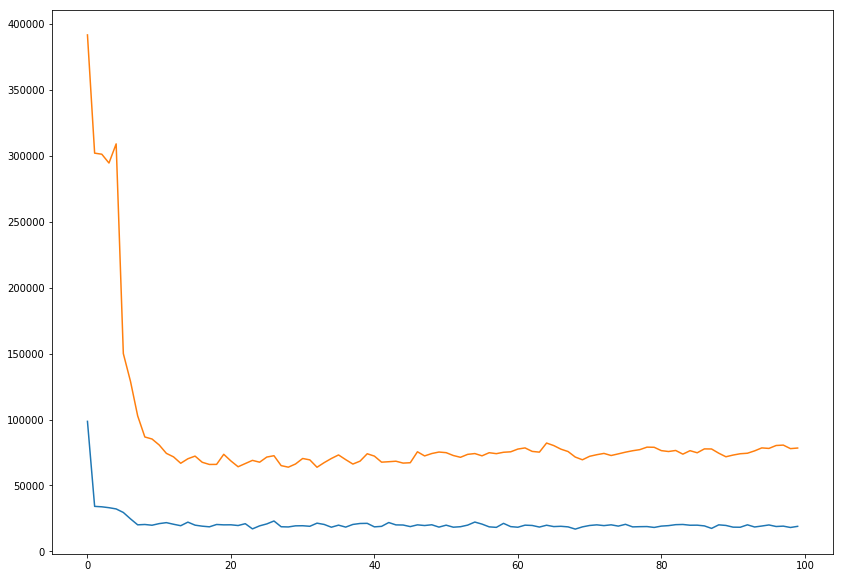

In [170]:
plt.figure(figsize=(14,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

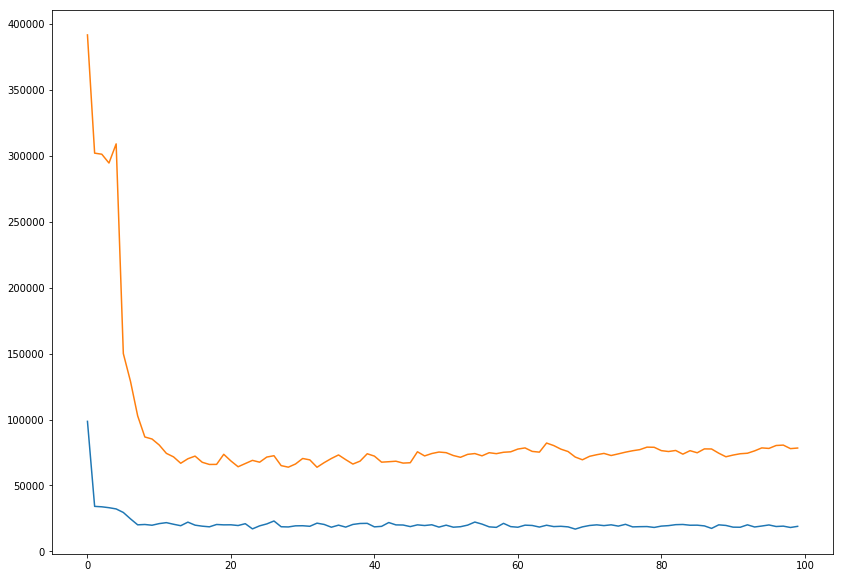

In [171]:
plt.figure(figsize=(14,10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])

In [172]:
predict_close=[]
predict_close = list(model.predict(X_test))


In [173]:
predicted_close=[]
for i in range(len(y_test)):
    predicted_close.append((predict_close[i][0][0]))
predicted_close

[738.28906,
 738.2397,
 738.2642,
 738.3504,
 738.4115,
 738.4811,
 738.5953,
 738.64355,
 738.6089,
 738.71454,
 738.852,
 739.01117,
 738.91,
 738.86053,
 738.91296,
 738.9535,
 739.1585,
 739.25806,
 739.25024,
 739.3668,
 739.48083,
 739.49536,
 739.6799,
 739.55493,
 739.74756,
 739.4717,
 739.4698,
 739.60626,
 739.42487,
 739.223,
 739.2879,
 739.41565,
 739.5435,
 739.6802,
 739.65045,
 739.70917,
 739.8136,
 739.80536,
 739.8178,
 739.903,
 739.91595,
 739.91455,
 739.86633,
 739.78577,
 739.87103,
 739.97644,
 739.96924,
 740.0197,
 740.0951,
 740.18677,
 740.2207,
 740.182,
 740.1555,
 740.1355,
 740.0422,
 740.08496,
 740.13544,
 740.0783,
 739.9724,
 739.98706]

In [174]:
actual_close=[]
for i in range(len(y_test)):
    actual_close.append((y_test[i][0][0]))
actual_close

[1189.01,
 1204.2,
 1209.59,
 1229.14,
 1246.87,
 1252.7,
 1254.33,
 1276.68,
 1305.2,
 1304.86,
 1295.0,
 1293.32,
 1294.58,
 1327.31,
 1362.54,
 1357.51,
 1377.95,
 1402.05,
 1417.68,
 1437.82,
 1451.65,
 1390.0,
 1431.0,
 1396.62,
 1442.84,
 1416.78,
 1350.47,
 1338.99,
 1386.23,
 1414.51,
 1451.05,
 1461.76,
 1448.69,
 1468.35,
 1482.92,
 1484.76,
 1500.0,
 1521.95,
 1511.98,
 1512.45,
 1493.45,
 1500.25,
 1523.61,
 1537.64,
 1545.0,
 1551.86,
 1578.89,
 1598.39,
 1588.18,
 1591.0,
 1582.32,
 1571.68,
 1544.93,
 1586.51,
 1581.86,
 1544.1,
 1495.56,
 1555.86,
 1497.05,
 nan]

In [175]:
performance=pd.DataFrame([list(predicted_close),list(actual_close)])

In [176]:
performance=performance.T

In [177]:
performance.columns=['Predicted','Actual']
Spread=performance.Actual-performance.Predicted


In [178]:
performance.tail()

,Predicted,Actual
55,740.084961,1544.10
56,740.135437,1495.56
57,740.078308,1555.86
58,739.972412,1497.05
59,739.987061,NaN


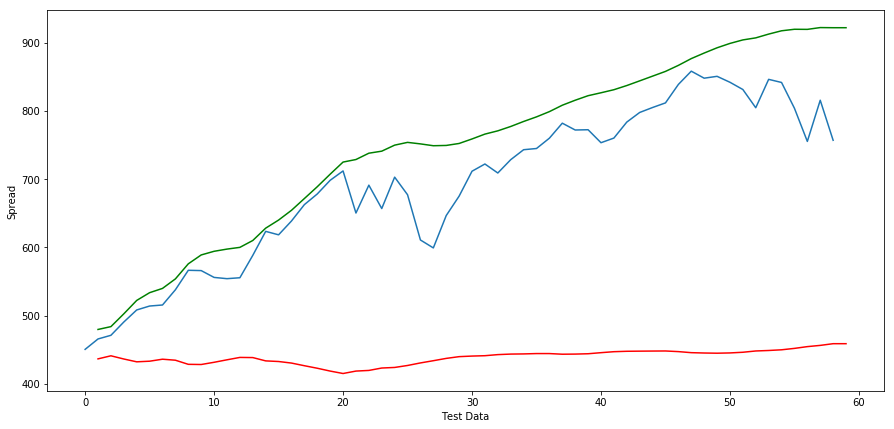

In [179]:
# Here s stands for the standard deviation range for the spread, beyond which we will consider the entry and exit positions
# Feel free to change this s value to generate different signals
s=2
plt.figure(figsize=(15,7))
plt.plot(Spread)
plt.plot(Spread.expanding().mean()+s*Spread.expanding().std(),c='g')
plt.plot(Spread.expanding().mean()-s*Spread.expanding().std(),c='r')
plt.ylabel('Spread')
plt.xlabel('Test Data')
plt.show()

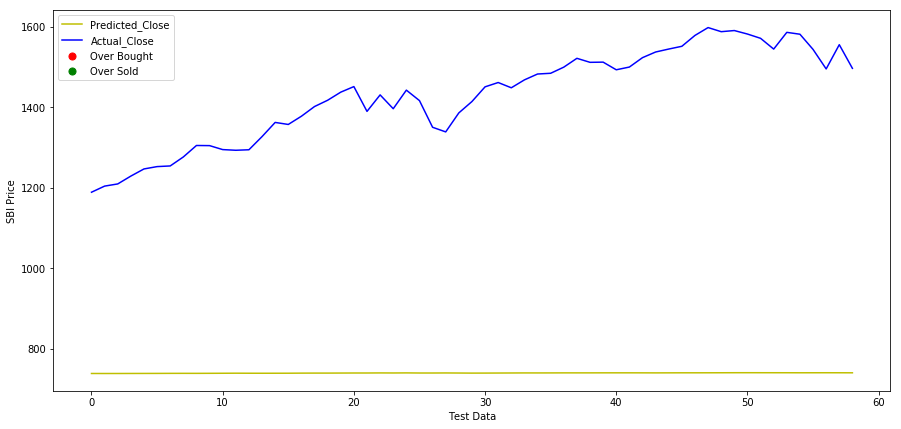

In [180]:
plt.figure(figsize=(15,7))
# Plot the predicted and actual prices for comparison
plt.plot(performance.Predicted.iloc[:-1],c='y')
plt.plot(performance.Actual,c='b')
# Plot the sell signlas wherever the Spread is above the upper standard deviation band
plt.scatter(performance.Actual[(Spread>Spread.expanding().mean()+s*Spread.expanding().std())].index,
            performance.Actual[(Spread>Spread.expanding().mean()+s*Spread.expanding().std())],c='r',s=50)
# Plot the buy signlas wherever the Spread is below the lower standard deviation band
plt.scatter(performance.Actual[(Spread<Spread.expanding().mean()-s*Spread.expanding().std())].index,
            performance.Actual[(Spread<Spread.expanding().mean()-s*Spread.expanding().std())],c='g',s=50)
plt.legend(['Predicted_Close','Actual_Close','Over Bought','Over Sold'])
plt.ylabel('SBI Price')
plt.xlabel('Test Data')
plt.show()
